# **Data Collecting**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/drive/My Drive/App/online retail 2.csv', parse_dates=['InvoiceDate'], encoding='latin1').iloc[:,:8]

In [0]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044848 entries, 0 to 1044847
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1044848 non-null  object        
 1   StockCode    1044848 non-null  object        
 2   Description  1040573 non-null  object        
 3   Quantity     1044848 non-null  int64         
 4   InvoiceDate  1044848 non-null  datetime64[ns]
 5   Price        1044848 non-null  float64       
 6   Customer ID  809561 non-null   float64       
 7   Country      1044848 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 63.8+ MB


In [0]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235287
Country             0
dtype: int64

In [0]:
df.describe()

,Quantity,Price,Customer ID
count,1.044848e+06,1.044848e+06,809561.000000
mean,9.993649e+00,4.590546e+00,15319.760422
std,1.742185e+02,1.217042e+02,1695.812057
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13969.000000
50%,3.000000e+00,2.100000e+00,15248.000000
75%,1.000000e+01,4.130000e+00,16792.000000
max,8.099500e+04,3.897000e+04,18287.000000


## Data Cleaning
I Impute null Customer ID with my own ID. I assume that for missing values in CustomerID per-Invoice are a different person.

In [0]:
df['Customer ID'] = df['Customer ID'].replace(np.nan,0)

notclean = df.groupby(['Invoice','Customer ID']).size().reset_index()

notclean = notclean[~notclean['Invoice'].str.contains('C')]

nullID = notclean[notclean['Customer ID'] == 0].reset_index(drop=True)

#ID Generator
p = 18288
for i in range(0,nullID.shape[0]):   
    nullID.loc[i,'Customer ID'] = p
    p+=1

nullID.drop(0,axis=1,inplace=True)

df = df.merge(nullID, on='Invoice', how='left')

df['Customer ID_y'] = df['Customer ID_y'].fillna(0)

df['CustomerID'] = df[['Customer ID_x','Customer ID_y']].apply(lambda x:  [i for i in x if i>0][0] if len([i for i in x if i>0]) > 0 else 0, axis = 1)

#Invoice with a C letter indicates cancellation, so I drop'em
df = df[~df.Invoice.str.contains('C')].drop(['Customer ID_x','Customer ID_y'], axis = 1)

In [0]:
df.isnull().sum() #We still have missing values in Description

Invoice           0
StockCode         0
Description    4275
Quantity          0
InvoiceDate       0
Price             0
Country           0
CustomerID        0
dtype: int64

In [0]:
df = df.dropna(subset=['Description'])

In [0]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Country        0
CustomerID     0
dtype: int64

In [0]:
df.shape 

(1021408, 8)

# **EDA**

For EDA, let's explore of some questions:
#####1. **Which customers spent the most money?**

In [0]:
#@title
no1 = df[df.Price>0].reset_index(drop=True)
no1['amount'] = no1.Price*no1.Quantity
no1 = no1.groupby('CustomerID')['amount'].sum().sort_values(ascending=False).head(1)
print('Customer ID {} spent most of money, with total of £{:6.0f}'.format(int(no1.index[0]),no1.values[0]))

Customer ID 18102 spent most of money, with total of £580987


#####2. **Average items in one transactions**

In [0]:
#@title
no2 = df[df.Price>0].reset_index(drop=True)
print('Average items in one transactions is {:2.0f}. From this number we could suggest that many of the customers seems to be organizational customers rather than individual'.format(
            no2.groupby(['Invoice']).size().mean()))

Average items in one transactions is 25. From this number we could suggest that many of the customers seems to be organizational customers rather than individual


#####3. **Which month most of transactions occurred**

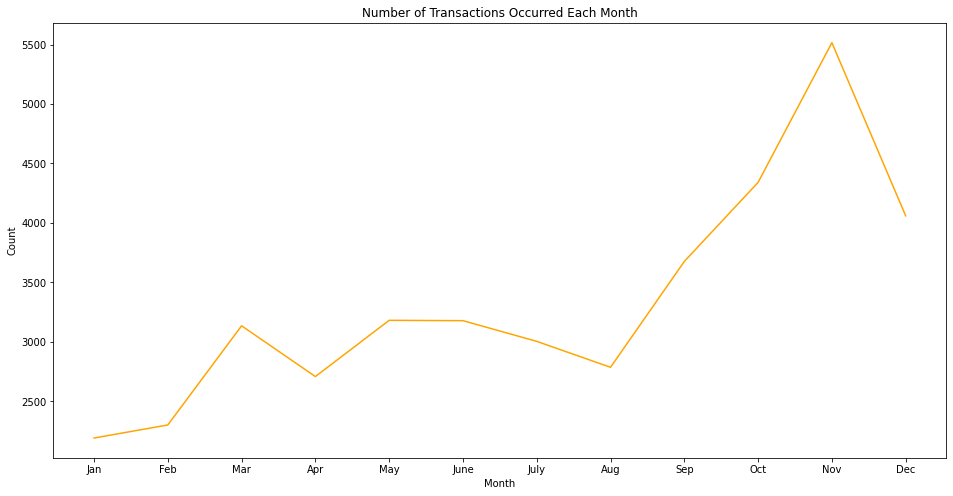

In [0]:
#@title
no3 = df[df.Price>0].reset_index(drop=True)
ans = no3.groupby(no3.InvoiceDate.dt.month)['Invoice'].nunique()

fig,ax=plt.subplots(figsize=(16,8))

ax = sns.lineplot(x = ans.index, y =ans.values, color='orange').set(title='Number of Transactions Occurred Each Month',xlabel='Month',ylabel='Count')
ax = plt.xticks(ans.index,['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'])

November has most transactions happened. It seems people shopped a lot to welcome holiday in December

#####4. **Transactions trend over 2 years**

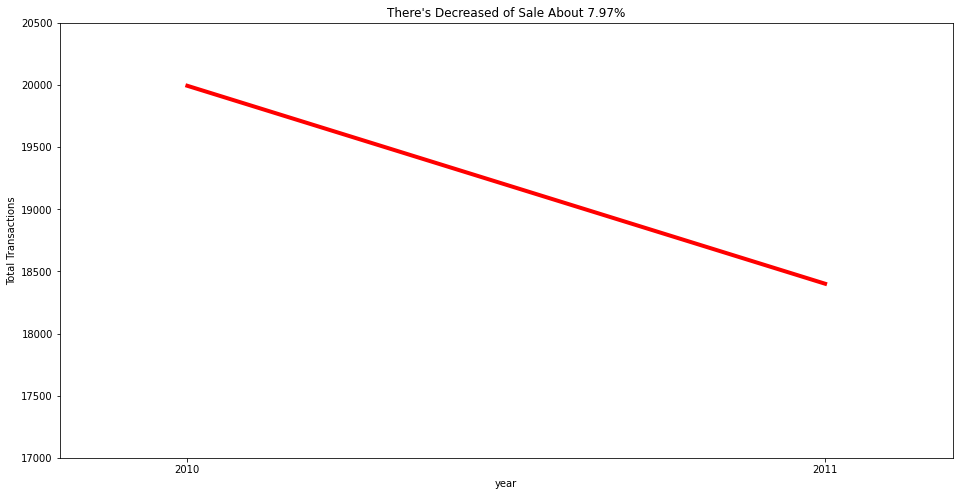

In [0]:
#@title
no4 = df[df.Price>0].reset_index(drop=True)

no4['year'] = no4.InvoiceDate.dt.year

k = no4.groupby('year')['Invoice'].nunique().tail(2)

fig,ax = plt.subplots(figsize=(16,8))

rate = (k[2010] - k[2011])/k[2010]*100

ax = sns.lineplot(x=k.index,y=k.values, color='red', linewidth=4 ).set(title=("There's Decreased of Sale About "+str(np.round(rate,2))+'%'),ylabel='Total Transactions')

ax = plt.xticks([2010,2011])

ax = plt.xlim(2009.8,2011.2)
ax = plt.ylim(17000,20500)




The Decreased of the sale is not big, but could be improve

#####5. **Customer Retention**


>Customer retention rate designates the percentage of customers the company has retained over a given time period. Retention rate is a reverse side of churn rate, which shows the percentage of customers a company has lost over a specific period. The importance of retention rate as a metric varies depending on the industry, for example for businesses providing services or selling software goods, customer retention is crucial and it directly affects profitability of the business.




In [0]:
#@title
from datetime import datetime as dt

no5 = df[df.Price>0].reset_index(drop=True)
first_year = no4[no5.InvoiceDate < dt.strptime("12/2/2010", '%m/%d/%Y')]
second_year = no4[(no5.InvoiceDate < dt.strptime("12/2/2011", '%m/%d/%Y'))&(no5.InvoiceDate > dt.strptime("12/2/2010", '%m/%d/%Y'))]

second_index = np.array(second_year.groupby('CustomerID').size().index)
first_index = np.array(first_year.groupby('CustomerID').size().index)
new_cust = 0
for x in second_index:
    if x in first_index:
        new_cust+=1

cust_ret = (second_year.groupby('CustomerID').size().shape[0] - new_cust)/(first_year.groupby('CustomerID').size().shape[0])*100

print('In the first year, the store has: {} Customers.\nIn the second year (end periode), the store has: {} customers.\nThe store acquired {} new customers.\nThe store lose {} customers.\nCustomer retention rate: {:2.1f}%'.format(first_index.shape[0],second_index.shape[0],new_cust,second_index.shape[0]-new_cust,cust_ret))

In the first year, the store has: 5958 Customers.
In the second year (end periode), the store has: 5666 customers.
The store acquired 2701 new customers.
The store lose 2965 customers.
Customer retention rate: 49.8%


The rate is quite bad, because we lose customers more than we acquire customers. Each companies have their own 'good' and 'bad' standard, but for me, this rate is bad for business because acquiring new customers is cost more than retain old customers.

#####6. **Most Purchased Items**

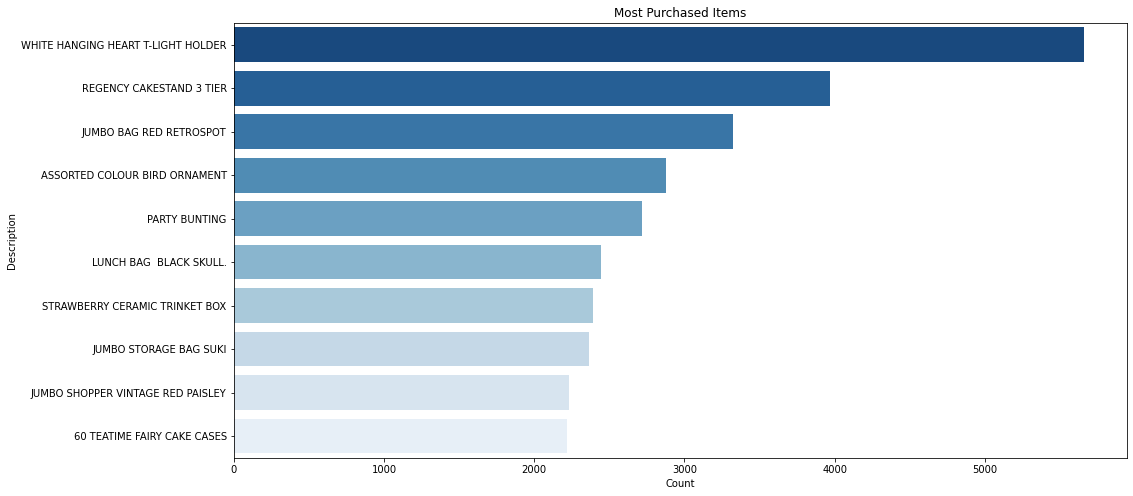

In [0]:
#@title
no6 = df[df.Price>0].reset_index(drop=True)

no6 = no6.groupby('Description').size().sort_values(ascending=False).reset_index().rename(columns={0:'Count'}).head(10)
fig,ax=plt.subplots(figsize=(16,8))

ax = sns.barplot(y = 'Description', x='Count', data=no6, palette='Blues_r').set(title='Most Purchased Items')


#####7. **Most Expensive Items**

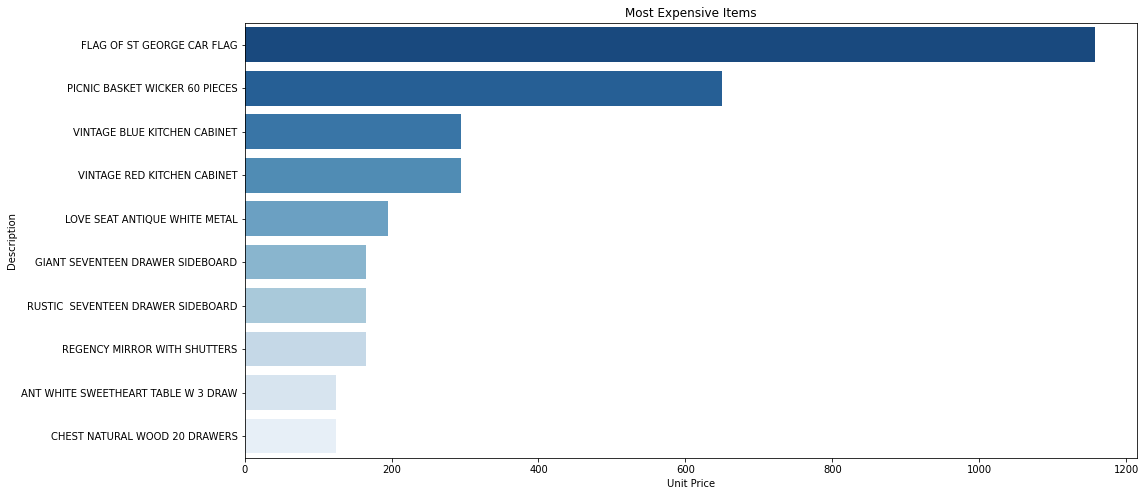

In [0]:
#@title
no7 = df[~df.StockCode.str.contains('[A-Za-z]')].sort_values('Price').reset_index(drop=True).groupby('Description')['Price'].max().sort_values(ascending=False)

fig,ax=plt.subplots(figsize=(16,8))
ax = sns.barplot(y = no7.index[:10], x=no7.values[:10], palette='Blues_r').set(title='Most Expensive Items', xlabel='Unit Price')

#####8. **Most expensive postage**

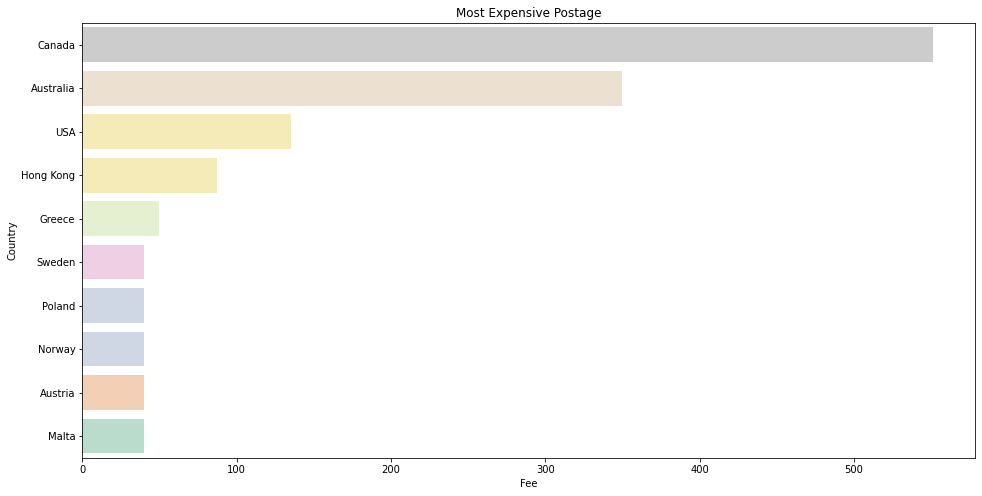

In [0]:
#@title
post = df[df.StockCode.str.contains('POST')][['Price','Country']].groupby('Country')['Price'].median().sort_values(ascending=False).head(10)

fig,ax=plt.subplots(figsize=(16,8))
ax = sns.barplot(y = post.index, x=post.values, palette='Pastel2_r').set(title='Most Expensive Postage', xlabel='Fee')

Postage to Canada is so expensive. Interestingly, postage to Australia is cheaper than to Canada altough the distance is very far .

# **Customer Segmentation**

<img src='https://denary.wpengine.com/wp-content/uploads/2014/07/picture_market_segmentation-10-4-13-resized-600.png'>

Customer segmentation is the practice of **dividing a customer base into groups of individuals that are similar in specific ways** relevant to marketing. Customer segmentation relies on identifying key differentiators that divide customers into groups that can be targeted. Information such as a customers' demographics (age, race, religion, gender, family size, ethnicity, income, education level), geography (where they live and work), psychographic (social class, lifestyle and personality characteristics) and behavioral (spending, consumption, usage and desired benefits) tendencies are taken into account when determining customer segmentation practices.<br>

<br>By enabling companies to target specific groups of customers, a customer segmentation model allows for the effective allocation of marketing resources and the maximization of cross- and up-selling opportunities. When a group of customers is sent personalized messages as part of a marketing mix that is designed around their needs, it's easier for companies to send those customers special offers meant to encourage them to buy more products. Customer segmentation can also improve customer service and assist in customer loyalty and retention. As a by-product of its personalized nature, marketing materials sent out using customer segmentation tend to be more valued and appreciated by the customer who receives them as opposed to impersonal brand messaging that doesn't acknowledge purchase history or any kind of customer relationship.

## **Country Based Segmentation**

Because the dataset is UK-based retail, so I'll see how many customers from another country

In [0]:
#@title
country_count = df[['Country']]
country_count['Country'] = country_count.Country.apply(lambda x: 'Other' if x != 'United Kingdom' else x)
country_count = country_count.groupby('Country').size().reset_index().sort_values(0,ascending=False).rename(columns={0:'Count'})

import plotly.express as px
fig = px.pie(country_count, values='Count', names='Country', color_discrete_sequence=px.colors.sequential.Plasma_r,  title='Country Origin Composition of the Customers')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Based on Pie Chart, we could see that **8.03%** of customers are from other country. Next, let's see, country portion included in other country. 

In [0]:
#@title
notuk = df[df.Country != 'United Kingdom']
notuk = notuk.groupby('Country').size().reset_index().sort_values(0,ascending=False).rename(columns={0:'Count'})

import plotly.express as px
fig = px.pie(notuk, values='Count', names='Country', color_discrete_sequence=px.colors.sequential.Plasma_r,  title='non-UK Customers Segment')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

So, for non-UK customers, most of them are from Ireland and Germany. We could see that these countries have potential to spread the market share, and as market campaign target.

## **Customer Behavior Based Segmentation**

<img src='https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png'>

For customer behavior segmentation, I used RFM analysis.

> **What is RFM Analysis?**

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.<br>
<br>RFM factors illustrate these facts:

*   the more recent the purchase, the more responsive the customer is to promotions
*   the more frequently the customer buys, the more engaged and satisfied they are
*   the more frequently the customer buys, the more engaged and satisfied they are
monetary value differentiates heavy spenders from low-value purchasers




In [0]:
df.describe()

,Quantity,Price,CustomerID
count,1.021408e+06,1.021408e+06,1.021408e+06
mean,1.076460e+01,3.894196e+00,1.710289e+04
std,1.327524e+02,9.457473e+01,3.794325e+03
min,-9.600000e+03,-5.359436e+04,1.234600e+04
25%,1.000000e+00,1.250000e+00,1.436700e+04
50%,3.000000e+00,2.100000e+00,1.616600e+04
75%,1.100000e+01,4.130000e+00,1.804100e+04
max,8.099500e+04,2.511109e+04,2.664800e+04


The data is not clean. There's still negative values for Quantity and Price

In [0]:
clean = df[(df.Quantity>0)&(df.Price>0)].reset_index(drop=True)
clean.shape

(1019654, 8)

### Recency (in days)

In [0]:
#@title
recency = pd.DataFrame(clean.CustomerID).merge(pd.DataFrame((clean.InvoiceDate.max()-clean.InvoiceDate).dt.days).rename(columns={'InvoiceDate':'last_shop'}), left_index=True, right_index=True)
recency = pd.DataFrame(recency.groupby('CustomerID')['last_shop'].min()).reset_index()
recency

,CustomerID,last_shop
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
8981,26639.0,0
8982,26640.0,0
8983,26641.0,0
8984,26642.0,0


### Total Shopping (Monetary)

In [0]:
#@title
clean['amount'] = clean.Quantity*clean.Price
amount = pd.DataFrame(clean.groupby('CustomerID')['amount'].sum()).reset_index()
amount.head()

,CustomerID,amount
0,12346.0,77556.46
1,12347.0,4921.53
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40


### Shopping Frequency

In [0]:
#@title
freq = clean.reset_index().groupby('CustomerID')['Invoice'].nunique().reset_index().rename(columns={'Invoice':'freq'})
freq.head()

,CustomerID,freq
0,12346.0,12
1,12347.0,8
2,12348.0,5
3,12349.0,4
4,12350.0,1


### Merge it All

In [0]:
#@title
cust_seg = amount.merge(recency,on='CustomerID').merge(freq,on='CustomerID')

#cust_seg['Behavior'] = cust_seg.Behavior.astype('int')
custID = cust_seg.CustomerID
cust_seg = cust_seg.drop(columns=['CustomerID'])
cust_seg

,amount,last_shop,freq
0,77556.46,325,12
1,4921.53,1,8
2,2019.40,74,5
3,4428.69,18,4
4,334.40,309,1
...,...,...,...
8981,6637.59,0,1
8982,7689.23,0,1
8983,3217.20,0,1
8984,5664.89,0,1


Visualize the distribution

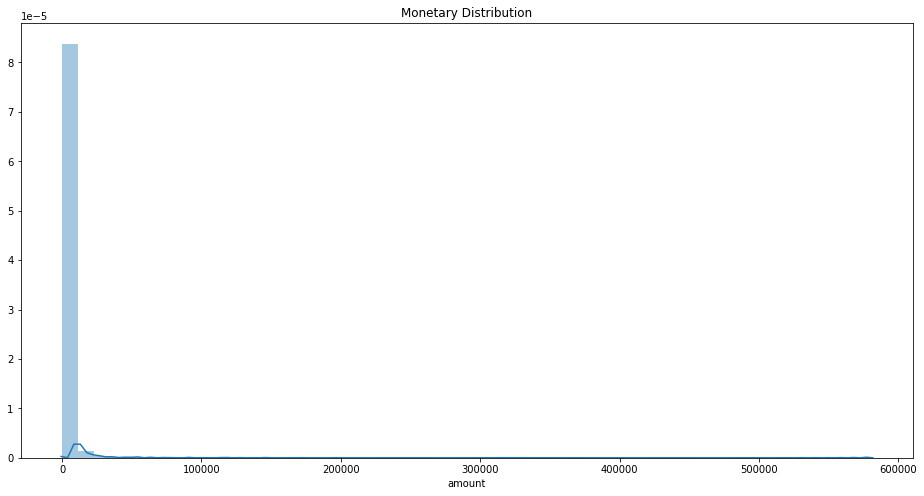

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(cust_seg.amount).set(title='Monetary Distribution')


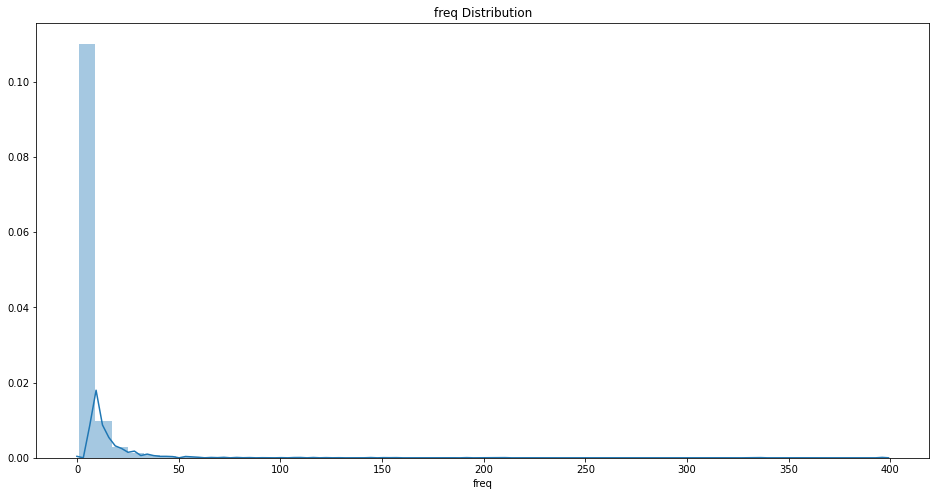

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(cust_seg.freq).set(title='freq Distribution')

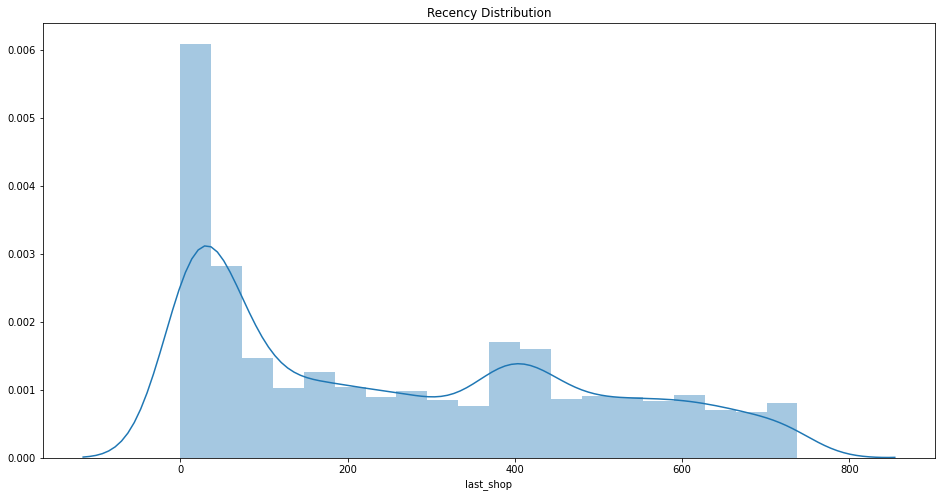

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(cust_seg.last_shop).set(title='Recency Distribution')

For all distribution, they are heavily skewed. I'll use power transformation to make'em more similar to normal distribution.

### Data Transform

In [0]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

power = PowerTransformer().fit(cust_seg)
X_scaled =power.transform(cust_seg)

#Standard Scaler to Scale the data
scaler = StandardScaler().fit(X_scaled)
X_scaled = scaler.transform(X_scaled)

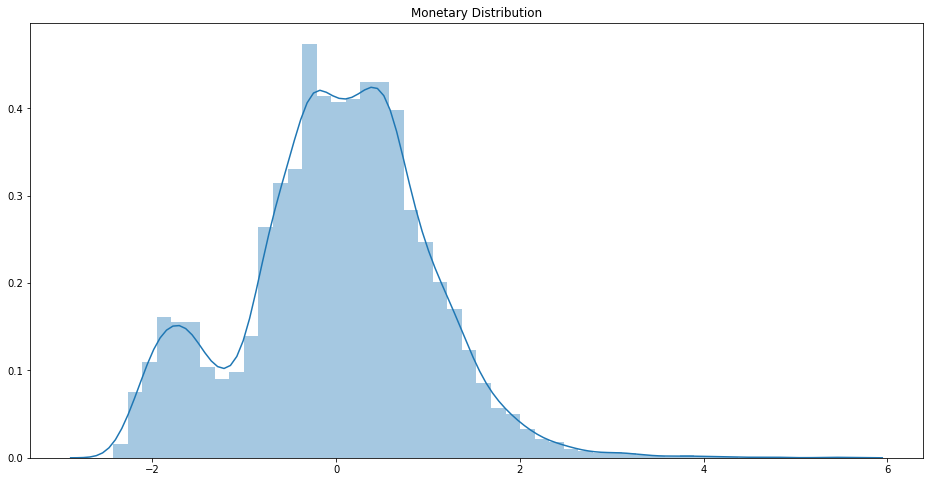

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(X_scaled[:,0]).set(title='Monetary Distribution')

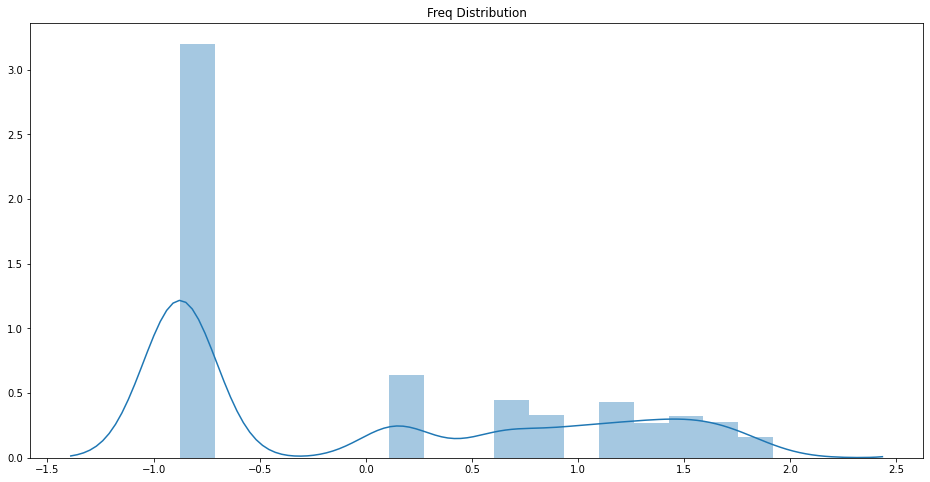

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(X_scaled[:,-1]).set(title='Freq Distribution')

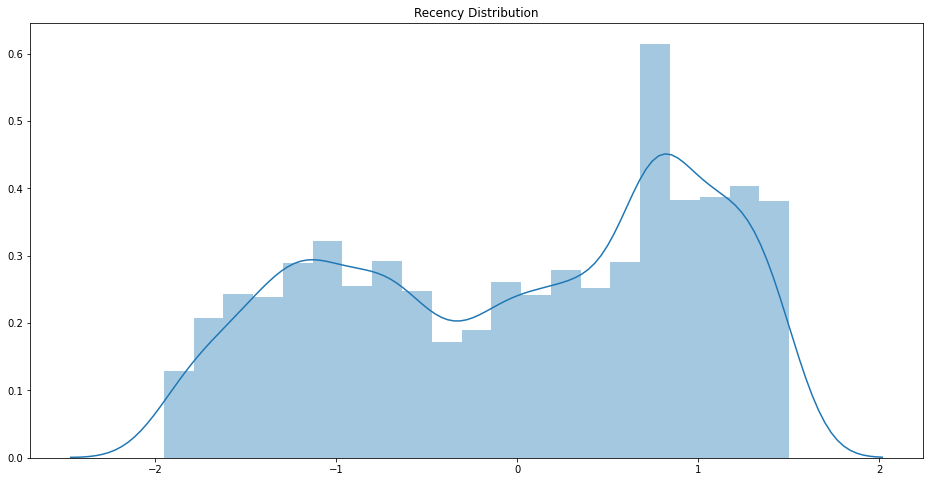

In [0]:
#@title
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.distplot(X_scaled[:,2]).set(title='Recency Distribution')

## **K-Means Clustering**
I'll use elbow method and silhouette analysis to determine best cluster for the data.

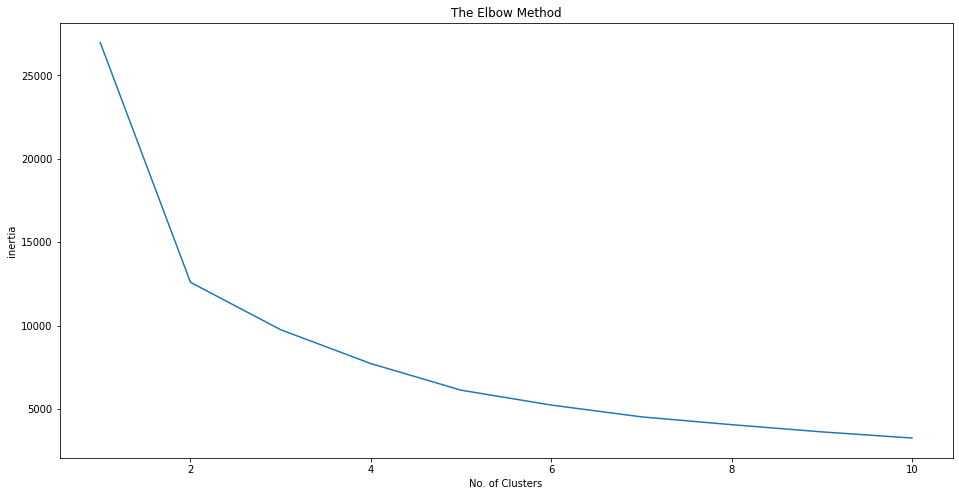

In [0]:
#@title
#Elbow Method
from sklearn.cluster import KMeans
inertia=[]
cl = 10

for i in range(1,cl+1):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

plt.plot(range(1,cl+1), inertia)
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('inertia')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4642101788521756
For n_clusters = 3 The average silhouette_score is : 0.34569023414007455
For n_clusters = 4 The average silhouette_score is : 0.3552964470888347
For n_clusters = 5 The average silhouette_score is : 0.3764087844325737
For n_clusters = 6 The average silhouette_score is : 0.3559140191311846


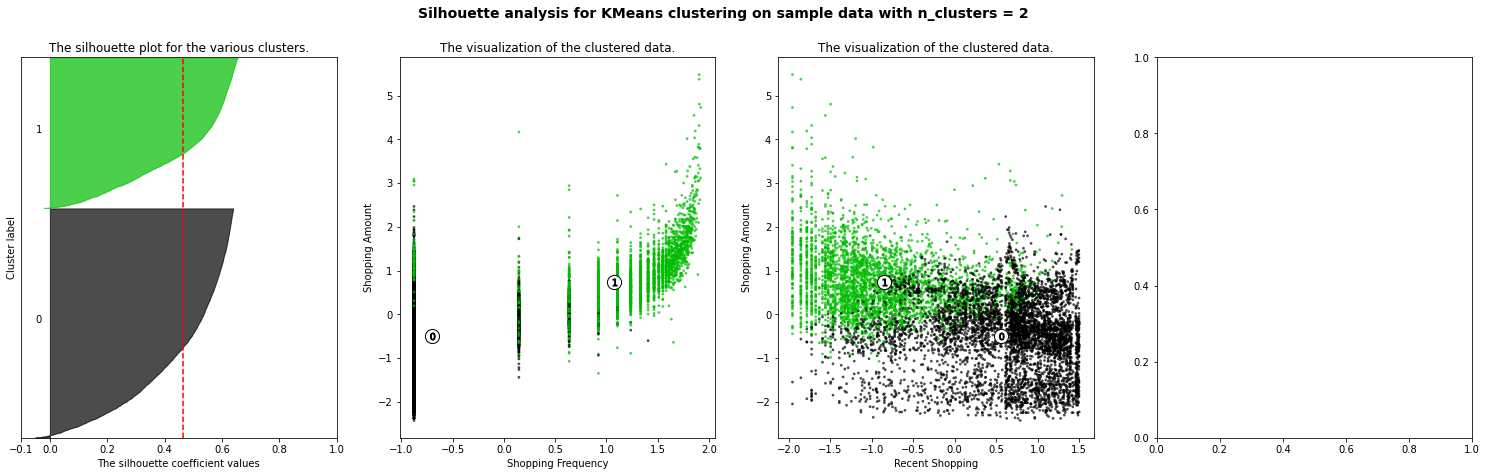

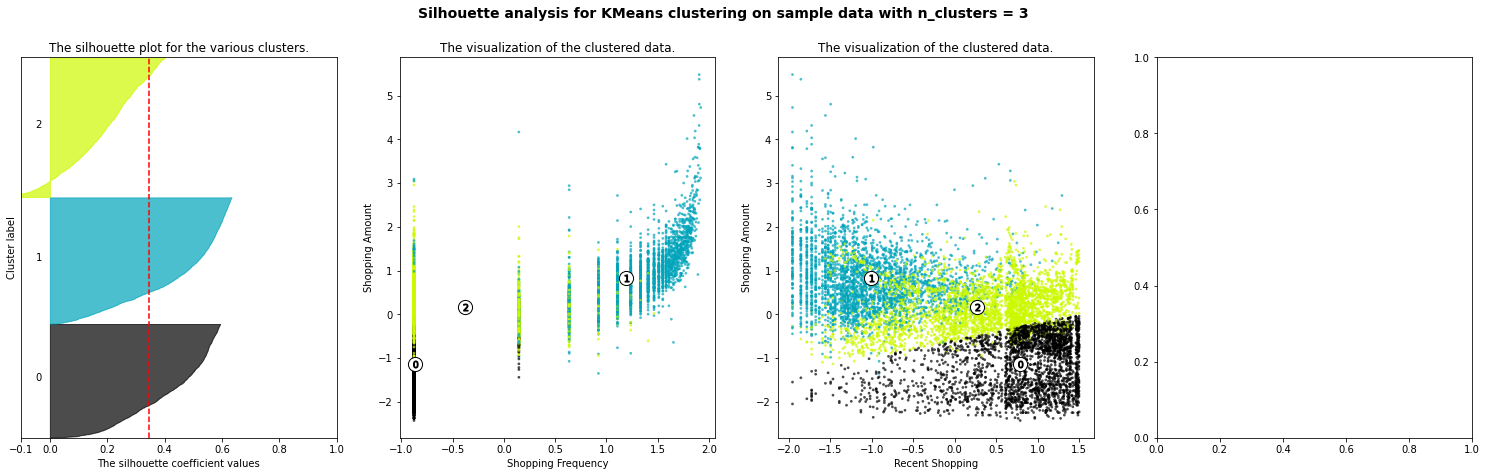

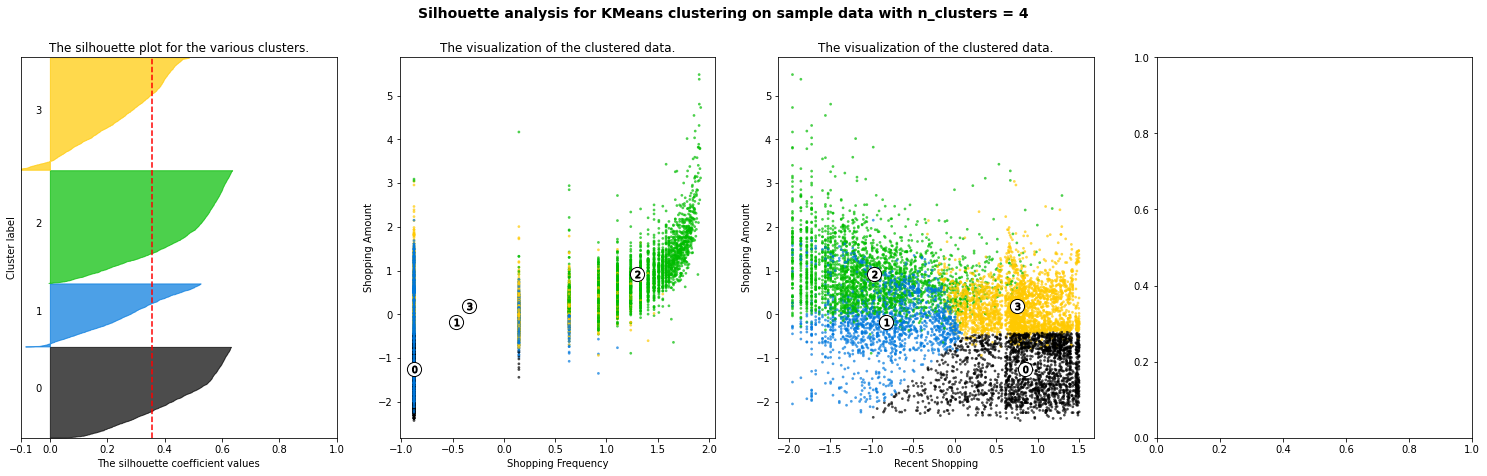

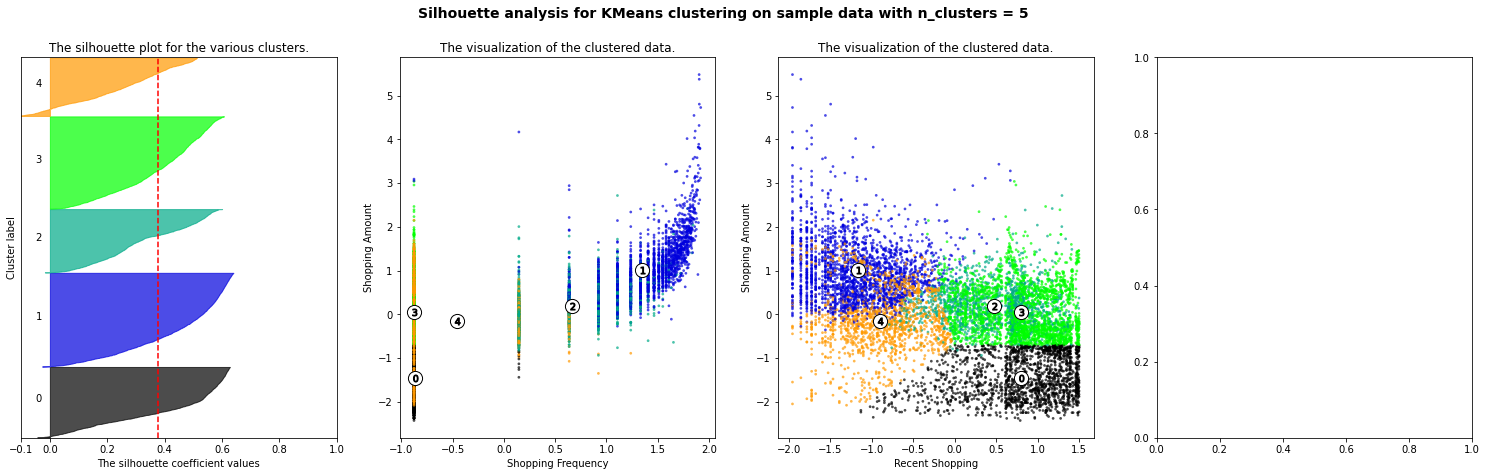

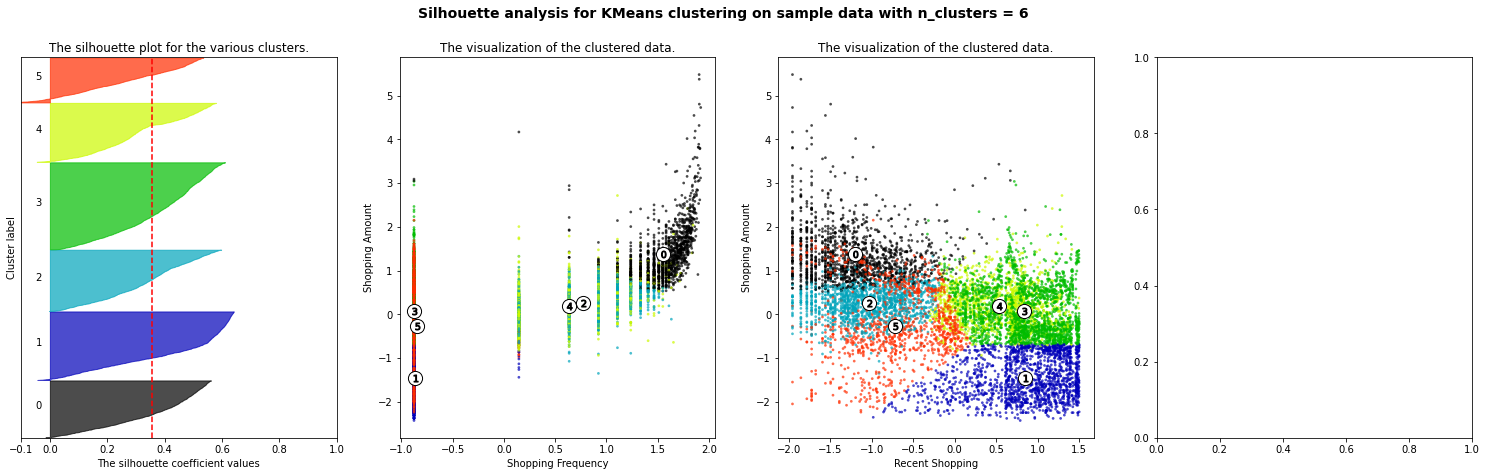

In [0]:
#@title
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(26, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 2], X_scaled[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 2], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[2], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Shopping Frequency")
    ax2.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
        # 3nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax3.scatter(X_scaled[:, 1], X_scaled[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("The visualization of the clustered data.")
    ax3.set_xlabel("Recent Shopping")
    ax3.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    '''
    # 4nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax4.scatter(X_scaled[:, 1], X_scaled[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("The visualization of the clustered data.")
    ax4.set_xlabel("Shopping Periode")
    ax4.set_ylabel("Shopping Amount")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    '''

plt.show()

Because all of choosen clusters have silhouette score more than the average score, therefore all number clusters are valid. But in this analysis, I'll pick 5 clusters for more detail analysis and because the last elbow happened in 5 clusters.

In [0]:
n = 5

model = KMeans(n_clusters= n, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

centers = model.cluster_centers_

## **Drill Down the Clusters**

In [0]:
#Append labels/clusters to scaled and original dataframe
cust_seg['cluster'] = labels
gg = pd.DataFrame(X_scaled,columns=['amount','last_shop','freq'])
gg['Cluster'] = labels+1

3D visualization of clusters to make it easier to analyze

In [0]:
#@title
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=gg.amount,
    y=gg.last_shop,
    z=gg.freq,
    mode='markers',
    marker=dict(
        size=4,
        color=gg.Cluster,                # set color to an array/list of desired values
        colorscale='Portland',   # choose a colorscale
        opacity=0.4,
        showscale=True
    ),
    showlegend=False
)])

fig.add_trace(go.Scatter3d(
    x=centers[:,0],
    y=centers[:,1],
    z=centers[:,2],
    mode='markers+text',
    marker=dict(color='black',size=5),
    text=['1','2','3','4','5','6'],
    textposition="top center",
    textfont=dict(
        family="sans serif",
        size=22,
        color="black"
    ),
    showlegend=False
))

print('Clusters')

fig.update_layout(scene = dict(
                    xaxis_title='Amount',
                    yaxis_title='Recency',
                    zaxis_title='Freq'),
                    margin=dict(r=20, b=10, l=10, t=10))


fig.show()

Clusters


Let's see the center and clusters' description

In [0]:
#@title
clusters = []

for i in range(0,n):
    clusters.append(cust_seg[cust_seg.cluster==i])

values = power.inverse_transform(scaler.inverse_transform(centers))

for i in range(0,n):
    print('-----CLUSTER {}-----'.format(i+1))
    print('Number of Customers: {}'.format(clusters[i].shape[0]))
    print('Purchases Amonunt: £{:6.2f}'.format(values[i][0]))
    print('Purchases Frequency : {:4.0f}'.format(values[i][2]))
    print('Last Day Shopping: {:4.0f}\n'.format(values[i][1]))

-----CLUSTER 1-----
Number of Customers: 2196
Purchases Amonunt: £671.76
Purchases Frequency :    1
Last Day Shopping:  419

-----CLUSTER 2-----
Number of Customers: 2228
Purchases Amonunt: £3312.84
Purchases Frequency :    7
Last Day Shopping:   25

-----CLUSTER 3-----
Number of Customers: 1673
Purchases Amonunt: £ 22.55
Purchases Frequency :    1
Last Day Shopping:  419

-----CLUSTER 4-----
Number of Customers: 1384
Purchases Amonunt: £447.01
Purchases Frequency :    1
Last Day Shopping:   45

-----CLUSTER 5-----
Number of Customers: 1505
Purchases Amonunt: £862.12
Purchases Frequency :    3
Last Day Shopping:  306



So, let's see customer's segmentation description:<br>

- Cluster 2 is our **champion** cluster. Since they have are the most frequent, most recently, and spent a lot of money. Reward them!
- Cluster 3 seems to be the **least profit** customers because they shop rarely, and haven't been shopping for a long time, and only spent a little amount of money. They likely only shop occasionally.
- Cluster 5 seems to be our **high risk** customers. They spent quite lot of money, and used to shop frequently, but haven't been shopping for a long time.
- Cluster 1 seems to be out **can't loose them** customers. They spent quite lot money, but haven't shopping for a long time.
- Cluster 4 seems to be the **new comers**. They have small shopping frequency, but have recent activity.

In [0]:
#@title
pie_plot = gg.Cluster.apply(lambda x: 'High Risk' if x == 5 else("Can't Lose Them" if x in [1] else('Least Profit' if x == 3 else ('New Comers' if x == 4 else 'Champion')))).reset_index().groupby('Cluster').size()

fig = px.pie(pie_plot, values=pie_plot.values, names=pie_plot.index, color_discrete_sequence=px.colors.diverging.Portland,  title='Customers Segment Composition')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

It's good that we have big market share on Champion cluster, but overall portions of 'risky' clusters have more market share. To overcome this problems, we could use this segmentation to design market campaign, promo, and other offer more appropriate for each clusters.

# **Market Basket Analysis**

![alt text](https://miro.medium.com/max/2560/1*2uSqS4cTYNXylx5a16OjHw.png)


Market Basket Analysis is a technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence. A co-occurrence is when two or more things take place together. One of the methods is called **association-rules**.<br>

<br> Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain's feature extraction and abstract association capabilities from new uncategorized data.<br>

<br>Association rules are normally written like this: **{Diapers} -> {Beer}** which means that there is a strong relationship between customers that purchased diapers and also purchased beer in the same transaction.

In the above example, the {Diaper} is the **antecedent** and the {Beer} is the **consequent**. Both antecedents and consequents can have multiple items. In other words, {Diaper, Gum} -> {Beer, Chips} is a valid rule.

There're some terminology in association-rules:

>**Support** It is a measure of how frequently the collection of items occur together as a percentage of all transactions.<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1c6acacd3b17051205704b5d323c83fc737e5db1" style="left:50%">

>**Confidence** is interpreted as: How often items in B appear in transactions that contain A only. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/90324dedc399441696116eed3658fd17c5da4329" style="left:50%">


>**Lift** The Lift tells us how much better a rule is at predicting the result than just assuming the result in the first place. Greater lift values indicate stronger associations. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c392e3111167b60687405dfdc7ed55f22409f4c5" style="left:50%">


## Market Basket Analysis in General

In [0]:
from mlxtend.frequent_patterns import apriori as ap
from mlxtend.frequent_patterns import association_rules

basket = clean.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')


basket_sets = basket.applymap(lambda x: 0 if x<=0 else 1)
basket_sets.drop(['DOTCOM POSTAGE','POSTAGE'], inplace=True, axis=1)

frequent_itemsets = ap(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.8).iloc[:,:7]
rules.sort_values(['antecedent support','confidence','lift'], ascending=False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
599,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.136113,0.043915,0.030940,0.227314,5.176181
663,(WHITE HANGING HEART T-LIGHT HOLDER),(WOODEN FRAME ANTIQUE WHITE ),0.136113,0.051376,0.020935,0.153804,2.993685
665,(WHITE HANGING HEART T-LIGHT HOLDER),(WOODEN PICTURE FRAME WHITE FINISH),0.136113,0.050054,0.020785,0.152704,3.050806
195,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER SMALL),0.136113,0.053672,0.019463,0.142988,2.664125
617,(WHITE HANGING HEART T-LIGHT HOLDER),(REGENCY CAKESTAND 3 TIER),0.136113,0.097762,0.019088,0.140238,1.434490


Let's take a look at the most popular item, **White Hanging Heart T-Light Holder**. At the first row of the dataframe, we could see that White Hanging Heart T-Light Holder **appear in 13% of the transaction**, and have a chance of **22%** that customers also bought a **Red Hanging Heart T-Light Holder**.


## Market Basket Analysis for Champion Cluster

### Data Preparation

In [0]:
data = pd.DataFrame(custID).merge(cust_seg, on=cust_seg.index).drop('key_0',axis=1).drop(['amount','freq'], axis=1)
data_ready = clean.merge(data, on='CustomerID')
data_ready

### Champion Cluster Basket Analysis

In [0]:
#@title
clust2 = data_ready[data_ready.cluster==2]

basket_c2 = clust2.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

In [0]:
#@title
clust2 = data_ready[data_ready.cluster==2]

basket_c2 = clust2.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')


basket_sets = basket_c2.applymap(lambda x: 0 if x<=0 else 1)
basket_sets.drop(['DOTCOM POSTAGE','POSTAGE'], inplace=True, axis=1)

frequent_itemsets = ap(basket_sets, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.8).iloc[:,:7]

rules.sort_values(['antecedent support','confidence','lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
4440,(REX CASH+CARRY JUMBO SHOPPER),(WHITE HANGING HEART T-LIGHT HOLDER),0.029115,0.026738,0.003565,0.122449,4.579592
177,(REX CASH+CARRY JUMBO SHOPPER),(3D DOG PICTURE PLAYING CARDS),0.029115,0.004159,0.001783,0.061224,14.720117
4433,(REX CASH+CARRY JUMBO SHOPPER),(SET/5 RED SPOTTY LID GLASS BOWLS),0.029115,0.004159,0.001783,0.061224,14.720117
11860,(REX CASH+CARRY JUMBO SHOPPER),"(RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI...",0.029115,0.005348,0.001783,0.061224,11.448980
4418,(REX CASH+CARRY JUMBO SHOPPER),(SANDALWOOD FAN),0.029115,0.005942,0.001783,0.061224,10.304082
3068,(REX CASH+CARRY JUMBO SHOPPER),(JUMBO BAG SCANDINAVIAN PAISLEY),0.029115,0.007130,0.001783,0.061224,8.586735
3853,(REX CASH+CARRY JUMBO SHOPPER),(PACK OF 6 BIRDY GIFT TAGS),0.029115,0.007130,0.001783,0.061224,8.586735
4331,(REX CASH+CARRY JUMBO SHOPPER),(RED HANGING HEART T-LIGHT HOLDER),0.029115,0.007724,0.001783,0.061224,7.926217
4420,(REX CASH+CARRY JUMBO SHOPPER),(SCANDINAVIAN PAISLEY PICNIC BAG),0.029115,0.007724,0.001783,0.061224,7.926217
3040,(REX CASH+CARRY JUMBO SHOPPER),(JUMBO BAG RED RETROSPOT),0.029115,0.011884,0.001783,0.061224,5.152041


Most transactions in Champion cluster involve the purchased of REX CASH+CARRY JUMBO SHOPPER with 2.9% of all transactions. WHITE HANGING HEART T-LIGHT HOLDER has the highest confidence, 12% of probability to being purchased along with REX CASH+CARRY JUMBO SHOPPER.

# **Conclusion**

1. Power transformation (log) is powerful to transform heavily skewed data to normal-ish data.
2. K-means also a powerful algorithm to cluster data
3. With Elbow method and silhouette score, we could determine the best cluster. We could find the highest silhouette score, and the last elbow happened.
4. With RFM analysis and K-means, we had 5 segmentation from the data, with the highest market share is the **Champion** cluster.
5. Market basket analysis could be done with association rules, and apriori algorithm.
6. For all clusters, we had White Hanging Heart T-Light Holder as the most popular items and most likely to be bought along with Red Hanging Heart T-Light Holder.
7. For Champion clusters, we had  REX CASH+CARRY JUMBO SHOPPER as the most popular items and most likely to be bought along with WHITE HANGING HEART T-LIGHT HOLDER.
8. With this market basket analysis, a business could make a cross selling to maximize customers satisfaction and maximize the purchase.